# Trying Basic Machine Learning Models as Comparison for Our DL Models 

## Random Forest

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split

fc_dir = "fc_matrices"
all_subjects = sorted([f.replace("_fc.npy", "") for f in os.listdir(fc_dir) if f.endswith("_fc.npy")])

# subject level split 
train_subs, test_subs = train_test_split(all_subjects, test_size=0.2, random_state=42)

def load_data(subject_list):
    X, y_class, y_reg = [], [], []
    for subj in subject_list:
        fc = np.load(os.path.join(fc_dir, f"{subj}_fc.npy"))
        labels = pd.read_csv(os.path.join(fc_dir, f"{subj}_labels.csv"))

        fc_flat = fc.reshape(fc.shape[0], -1)
        X.append(fc_flat)
        y_class.extend(labels["binned_by_mean"].values)
        y_reg.extend(labels["mean_scaled_anxiety"].values)
    
    return np.vstack(X), np.array(y_class), np.array(y_reg)

# load train and test sets 
X_train, y_train_class, y_train_reg = load_data(train_subs)
X_test,  y_test_class,  y_test_reg  = load_data(test_subs)

print(f"Train subjects: {len(train_subs)}, Test subjects: {len(test_subs)}")
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# classification
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_class, y_pred_class))

# regression
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train_reg)
y_pred_reg = reg.predict(X_test)

print("\nRegression MSE (Test Set):", mean_squared_error(y_test_reg, y_pred_reg))

Train subjects: 24, Test subjects: 6
Train samples: 2184, Test samples: 546

Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.76      0.19      0.31       150
         low       1.00      0.01      0.03        78
      medium       0.62      0.99      0.76       318

    accuracy                           0.63       546
   macro avg       0.79      0.40      0.37       546
weighted avg       0.71      0.63      0.53       546



## Regression Evaluation Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Regression Evaluation Metrics:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

📊 Regression Evaluation Metrics:
  • MSE:  0.0292
  • RMSE: 0.1708
  • MAE:  0.1399
  • R²:   0.3070


## Regression Predicted vs True Anxiety Scores plot 

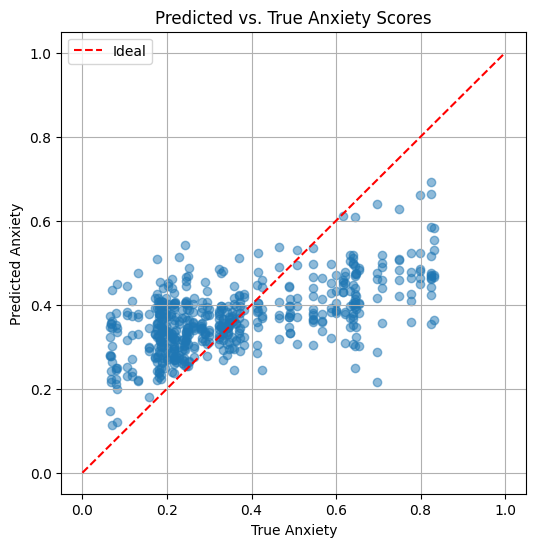

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')  # Line y = x
plt.xlabel("True Anxiety")
plt.ylabel("Predicted Anxiety")
plt.title("Predicted vs. True Anxiety Scores")
plt.legend()
plt.grid(True)
plt.show()

## Try with balanced class weights 

In [ ]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)

print("\n🎯 Classification Report (Test Set):")
print(classification_report(y_test_class, y_pred_class))


🎯 Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.94      0.19      0.32       150
         low       0.70      0.09      0.16        78
      medium       0.62      0.98      0.76       318

    accuracy                           0.64       546
   macro avg       0.75      0.42      0.41       546
weighted avg       0.72      0.64      0.55       546



# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os

X = []
y = []
subjects = []

fc_dir = "fc_matrices"
for fname in os.listdir(fc_dir):
    if fname.endswith("_labels.csv"):
        subj = fname.split("_")[0]
        label_path = os.path.join(fc_dir, fname)
        matrix_path = os.path.join(fc_dir, fname.replace("_labels.csv", "_fc.npy"))

        labels_df = pd.read_csv(label_path)
        fc_matrices = np.load(matrix_path)

        for i, row in labels_df.iterrows():
            fc_flat = fc_matrices[i].flatten()
            X.append(fc_flat)
            y.append(row["binned_by_mean"])
            subjects.append(subj)

X = np.array(X)
y = np.array(y)
subjects = np.array(subjects)

# train/test subject split 
unique_subjects = np.unique(subjects)
train_subj, test_subj = train_test_split(unique_subjects, test_size=0.2, random_state=42)

train_idx = np.isin(subjects, train_subj)
test_idx = np.isin(subjects, test_subj)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# SVM classifier 
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', class_weight='balanced', random_state=42))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# evaluate  
print("📊 SVM Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

📊 SVM Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.65      0.41      0.51       150
         low       0.66      0.32      0.43        78
      medium       0.66      0.86      0.75       318

    accuracy                           0.66       546
   macro avg       0.66      0.53      0.56       546
weighted avg       0.66      0.66      0.64       546



## PCA then classification

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

fc_dir = "fc_matrices"
label_suffix = "_labels.csv"
fc_suffix = "_fc.npy"
n_components = 50  
test_size = 0.2
random_state = 42

X = []
y = []
groups = []

for fname in os.listdir(fc_dir):
    if fname.endswith(label_suffix):
        subj = fname.split("_")[0]
        label_path = os.path.join(fc_dir, fname)
        fc_path = os.path.join(fc_dir, f"{subj}_fc.npy")

        if not os.path.exists(fc_path):
            continue

        fc_array = np.load(fc_path)  # shape: (n_windows, 100, 100)
        labels_df = pd.read_csv(label_path)

        for i in range(fc_array.shape[0]):
            fc = fc_array[i]
            vec = fc[np.triu_indices_from(fc, k=1)]  # flatten upper triangle
            X.append(vec)
            y.append(labels_df.loc[i, "binned_by_mean"])
            groups.append(subj)

X = np.array(X)
y = np.array(y)
groups = np.array(groups)

# train/test subject split 
splitter = GroupShuffleSplit(test_size=test_size, random_state=random_state)
train_idx, test_idx = next(splitter.split(X, y, groups=groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# PCA
pca = PCA(n_components=n_components, random_state=random_state)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# SVM
clf = SVC(class_weight='balanced', random_state=random_state)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

# evalute 
print("\n📊 SVM Classification Report (Test Set):")
print(classification_report(y_test, y_pred))


📊 SVM Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.54      0.50      0.52       150
         low       0.46      0.41      0.43        78
      medium       0.69      0.73      0.71       318

    accuracy                           0.62       546
   macro avg       0.56      0.55      0.55       546
weighted avg       0.61      0.62      0.62       546



# Gradient Boosted Trees 

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

fc_dir = "fc_matrices"

X = []
y = []
subjects = []

for fname in os.listdir(fc_dir):
    if fname.endswith("_fc.npy"):
        subj_id = fname.split("_")[0] 
        fc_path = os.path.join(fc_dir, fname)
        label_path = os.path.join(fc_dir, f"{subj_id}_labels.csv")

        fc = np.load(fc_path)

        labels_df = pd.read_csv(label_path)
        label_list = labels_df["binned_by_mean"].values

        for i in range(len(label_list)):
            X.append(fc[i].flatten())
            y.append(label_list[i])
            subjects.append(subj_id)

X = np.array(X)
y = np.array(y)
subjects = np.array(subjects)

print("✅ Data built:")
print("  • X shape:", X.shape)
print("  • y classes:", set(y))
print("  • # subjects:", len(set(subjects)))

# train/test subject split 
unique_subjects = np.unique(subjects)
train_subj, test_subj = train_test_split(unique_subjects, test_size=0.3, random_state=42)

train_mask = np.isin(subjects, train_subj)
test_mask = np.isin(subjects, test_subj)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# pca 
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# gradient boosted classifier 
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

# evaluate 
print("\n📊 Gradient Boosted Classifier Report (Test Set):")
print(classification_report(y_test, y_pred))

✅ Data built:
  • X shape: (2730, 10000)
  • y classes: {'medium', 'low', 'high'}
  • # subjects: 30

📊 Gradient Boosted Classifier Report (Test Set):
              precision    recall  f1-score   support

        high       0.57      0.34      0.42       225
         low       0.64      0.14      0.23       117
      medium       0.63      0.87      0.73       477

    accuracy                           0.62       819
   macro avg       0.61      0.45      0.46       819
weighted avg       0.61      0.62      0.57       819



In [17]:
# Try Hist Gradient Boosted Classifier 

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

clf = HistGradientBoostingClassifier(random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
clf.fit(X_train_pca, y_train, sample_weight=sample_weights)
y_pred = clf.predict(X_test_pca)

print("\n📊 Gradient Boosted Classifier Report (Test Set):")
print(classification_report(y_test, y_pred))



📊 Gradient Boosted Classifier Report (Test Set):
              precision    recall  f1-score   support

        high       0.60      0.43      0.50       225
         low       0.73      0.26      0.38       117
      medium       0.66      0.86      0.75       477

    accuracy                           0.65       819
   macro avg       0.66      0.51      0.54       819
weighted avg       0.66      0.65      0.63       819



In [24]:
from tphate import TPHATE

tphate = TPHATE(n_components=20, knn=5, decay=40)  # adjust as needed
X_train_tphate = tphate.fit_transform(X_train)
X_test_tphate = tphate.transform(X_test)

# === Train Gradient Boosted Trees ===
clf = HistGradientBoostingClassifier(random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
clf.fit(X_train_tphate, y_train)

# === Evaluate ===
y_pred = clf.predict(X_test_tphate)
print("📊 tPHATE + Gradient Boosted Trees Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

Calculating TPHATE...
  Running TPHATE on 1911 observations and 10000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.04 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.36 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 7.42 seconds.
  Learning the autocorrelation function...


/Users/emmasombers/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


  Calculating Autocorr kernel...
    Dropoff point: 68
  Combining PHATE operator and autocorr operator
  Calculating optimal t...
    Automatically selected t = 15
  Calculated optimal t in 3.73 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.11 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 183.93 seconds.
Calculated TPHATE in 211.85 seconds.
Calculating KNN search...


/Users/emmasombers/Library/Python/3.9/lib/python/site-packages/tphate/tphate.py:756: RuntimeWarning: Pre-fit TPHATE should not be used to transform a new data matrix. Please fit TPHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 0.15 seconds.
Calculating affinities...
Calculated affinities in 0.10 seconds.
📊 tPHATE + Gradient Boosted Trees Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.32      0.20      0.24       225
         low       0.31      0.09      0.13       117
      medium       0.59      0.80      0.68       477

    accuracy                           0.53       819
   macro avg       0.41      0.36      0.35       819
weighted avg       0.48      0.53      0.48       819



tphate does not work so well, maybe we will come back to it 

# Random Forest Comparison for just low vs high  

In [13]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split

# === CONFIG ===
fc_dir = "fc_matrices"
all_subjects = sorted([f.replace("_fc.npy", "") for f in os.listdir(fc_dir) if f.endswith("_fc.npy")])

# === SUBJECT-LEVEL SPLIT ===
train_subs, test_subs = train_test_split(all_subjects, test_size=0.2)

def load_filtered_data(subject_list):
    X, y_class, y_reg = [], [], []
    for subj in subject_list:
        fc = np.load(os.path.join(fc_dir, f"{subj}_fc.npy"))
        labels = pd.read_csv(os.path.join(fc_dir, f"{subj}_labels.csv"))

        # Filter to only 'low' and 'high'
        mask = labels["binned_by_mean"].isin(["low", "high"])
        fc = fc[mask.values]
        labels = labels[mask]

        # Encode: low = 0, high = 1
        y_class_vals = labels["binned_by_mean"].map({"low": 0, "high": 1}).values
        y_reg_vals = labels["mean_scaled_anxiety"].values

        fc_flat = fc.reshape(fc.shape[0], -1)
        X.append(fc_flat)
        y_class.extend(y_class_vals)
        y_reg.extend(y_reg_vals)

    return np.vstack(X), np.array(y_class), np.array(y_reg)

# === LOAD TRAIN + TEST SETS ===
X_train, y_train_class, y_train_reg = load_filtered_data(train_subs)
X_test,  y_test_class,  y_test_reg  = load_filtered_data(test_subs)

print(f"Train subjects: {len(train_subs)}, Test subjects: {len(test_subs)}")
print(f"Train samples (low/high only): {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# === CLASSIFICATION ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_class, y_pred_class, target_names=["Low", "High"]))

# === REGRESSION ===
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train_reg)
y_pred_reg = reg.predict(X_test)

print("\nRegression MSE (Test Set):", mean_squared_error(y_test_reg, y_pred_reg))

Train subjects: 24, Test subjects: 6
Train samples (low/high only): 912, Test samples: 228

Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.91      0.26      0.40        78
        High       0.72      0.99      0.83       150

    accuracy                           0.74       228
   macro avg       0.81      0.62      0.62       228
weighted avg       0.78      0.74      0.68       228



KeyboardInterrupt: 